# import uci dataset



In [ ]:
import pandas as pd

# Load directly from UCI repository URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

train_data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
train_data['income'] = train_data['income'].str.rstrip('.')
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
attributes_to_ignore = ['capital-gain','capital-loss']     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder
discrete_columns = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country','income']
train_data = train_data.drop(attributes_to_ignore, axis = 1)
train_data = train_data.dropna()
train_data = train_data.reset_index(drop=True)

In [ ]:
def rename_categorical_values(df):
    df = df.copy()  # Avoid modifying original DataFrame
    for col in df.select_dtypes(include=['object', 'category']).columns:
        unique_vals = df[col].unique()
        for val in unique_vals:
            if isinstance(val, str):
                # Find if this value exists in multiple columns
                count = sum((df[c] == val).any() for c in df.select_dtypes(include=['object', 'category']).columns)
                if count > 1:
                    df[col] = df[col].replace(val, f"{val}_{col}")
    return df

train_data = rename_categorical_values(train_data)

In [ ]:
num_features = 10
num_negatives = 5
discrete_columns = [c for c in train_data.columns if c in discrete_columns]    # puts disrete_columns in the right order

discrete_df = train_data[discrete_columns]

# Import csv dataset

In [ ]:
from google.colab import files

files.upload()    # Upload the training data csv. The following implementation drops the null values. Custom handling before uploading is encouraged

In [ ]:
dataset_name = '...'      # use the name .csv file imported above
discrete_columns = []
attributes_to_ignore = []     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder

num_features = 15
num_negatives = 5

In [ ]:
import pandas as pd

train_data = pd.read_csv(dataset_name)
train_data = train_data.dropna().reset_index(drop=True)
train_data = train_data.drop(attributes_to_ignore, axis = 1)
discrete_columns = [c for c in train_data.columns if c in discrete_columns]    # puts disrete_columns in the right order

discrete_df = train_data[discrete_columns]

# Embeddings


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset


class EmbeddingsNN(nn.Module):
    def __init__(self, discrete_df, num_features, num_negatives, pairs_pc, batch_size = 4000):
        """
        Initialize the embedding model.

        Args:
            discrete_df (pd.DataFrame): DataFrame with only discrete categorical columns.
            num_features (int): Embedding dimension size.
            num_negatives (int): Number of negative samples per positive sample.
            pairs_pc (float): Percentage of column pairs to sample for training.
            batch_size (int, optional): Batch size for training. Defaults to 4000.
        """
        super(EmbeddingsNN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.criterion = nn.BCELoss()
        self.num_epochs = 150
        self.num_negatives = num_negatives
        self.pairs_pc = pairs_pc
        self.batch_size = batch_size
        self.negtive_samples = []
        self.discrete_columns = discrete_df.columns
        self.num_words = self.compute_num_words(discrete_df)
        self.num_features = num_features
        self.f_matrix = self.get_f_matrix(self.word_occurance_pairs)
        self.column_pairs= [
        (col1, col2)
        for col1 in self.discrete_columns
        for col2 in self.discrete_columns
        if col1 != col2
        ]

        # E is the matrix we want to learn
        self.one_hot_matrix = torch.eye(self.num_words, device=self.device)
        self.E = nn.Parameter(torch.empty(self.num_words, self.num_features, device=self.device))  # Matrix E (learnable)
        self.theta = nn.Parameter(torch.empty(self.num_features, self.num_words, device=self.device))  # Vector θ (learnable)

        nn.init.xavier_uniform_(self.E)
        nn.init.xavier_uniform_(self.theta)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)

        self.to(self.device)


    def forward(self, idx_c, idx_t, batched=False):
        """
        Forward pass computes probability of co-occurrence between center and target words.

        Args:
            idx_c (Tensor or int): Indices of center words (batch or single).
            idx_t (Tensor or int): Indices of target words (batch or single).
            batched (bool): If True, treat inputs as batches.

        Returns:
            Tensor: Sigmoid probability of co-occurrence.
        """
        e_c = self.E[idx_c]
        theta_t = self.theta[:, idx_t]
        if batched:
            return torch.sigmoid(torch.sum((e_c *(theta_t.T)), dim=1))
        else:
            return torch.sigmoid(torch.dot(e_c, theta_t))

    def compute_num_words(self, discrete_df):
        """
        Compute the total number of unique discrete values ("words") and
        build word-to-index mapping.

        Args:
            discrete_df (pd.DataFrame): Input categorical data.

        Returns:
            int: Total number of unique words.
        """

        self.word_occurance_pairs = []
        self.values_per_column = [0]*len(self.discrete_columns)
        for column in self.discrete_columns:
            value_counts_pairs = discrete_df[column].value_counts().items()
            for v,c in value_counts_pairs:
              self.word_occurance_pairs.append([v,c])
              self.values_per_column[self.discrete_columns.get_loc(column)] += 1

        self.words = [word for word, count in self.word_occurance_pairs]
        self.word_to_idx = {word: idx for idx, word in enumerate(self.words)}
        return len(self.words)

    def get_f_matrix(self, word_occurance_pairs):
        """
        Compute negative sampling probabilities for each word.

        Args:
            word_occurance_pairs (list): List of [word, count] pairs.

        Returns:
            list: List of [index, probability] for negative sampling.
        """
        total = sum(x[1] for x in word_occurance_pairs)
        for i in range(len(word_occurance_pairs)):
          word_occurance_pairs[i][1] = word_occurance_pairs[i][1]/total
        sum_of_fs = sum(x[1]**(3/4) for x in word_occurance_pairs)
        f_matrix =[]
        for i in range(len(word_occurance_pairs)):
            f_matrix.append([i, word_occurance_pairs[i][1]**(3/4)/sum_of_fs])
        return f_matrix


    def get_training_pairs(self, pairs_pc, total_batch):
        """
        Sample positive training pairs (center-target) from random column pairs.

        Args:
            pairs_pc (float): Percentage of column pairs to sample.
            total_batch (pd.DataFrame): Current batch of data.

        Returns:
            Tensor: Training pairs of word indices with shape (num_pairs, 2).
        """
        num_pairs = int(len(self.column_pairs)*pairs_pc)
        pairs_set = random.sample(self.column_pairs, k=num_pairs)
        training_pairs = []
        for c, t in pairs_set:
          centers = total_batch[c].map(self.word_to_idx)
          targets = total_batch[t].map(self.word_to_idx)
          pairs = torch.stack([
              torch.tensor(centers.values, device=self.device),
              torch.tensor(targets.values, device=self.device)
          ], dim=1)
          training_pairs.append(pairs)

        # Concatenate all pairs from all column combinations
        training_pairs = torch.cat(training_pairs, dim=0)
        return training_pairs


    def get_negative_samples(self, positive_idxs, num_negatives):
        """
        Generate negative samples for each positive target index.

        Args:
            positive_idxs (Tensor): Indices of positive target words.
            num_negatives (int): Number of negatives to sample per positive.

        Returns:
            Tensor: Negative samples with shape (batch_size, num_negatives).
        """

        neg_samples = []
        numbers, probabilities = zip(*self.f_matrix)
        for _ in range(num_negatives):
            r = random.choices(numbers, weights=probabilities, k=len(positive_idxs))
            neg_samples.append(r)
        return torch.tensor(neg_samples, device = self.device).T


    def train(self):
        num_samples = len(discrete_df)
        counter = 0

        for epoch in range(self.num_epochs):
            total_loss = 0

            for i in range(0, num_samples, self.batch_size):
                counter+=1
                batch_df = discrete_df.iloc[i:i+self.batch_size]
                if len(batch_df) == 0:
                    continue

                training_pairs = self.get_training_pairs(self.pairs_pc, batch_df)
                targets = training_pairs[:, 1]
                negative_samples = self.get_negative_samples(targets, self.num_negatives)

                tp_exp = training_pairs[:, 0].repeat_interleave(negative_samples.shape[1])
                negative_samples = negative_samples.flatten()
                negative_samples = torch.stack([tp_exp, negative_samples], dim=1)

                self.optimizer.zero_grad()

                pos_scores = self.forward(training_pairs[:,0], training_pairs[:,1], batched=True)
                pos_loss = self.criterion(pos_scores, torch.ones_like(pos_scores))

                neg_scores = self.forward(negative_samples[:,0], negative_samples[:,1], batched=True)
                neg_loss = self.criterion(neg_scores, torch.zeros_like(neg_scores))

                loss = (pos_loss + neg_loss)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            if epoch%10 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss:.4f}")



In [ ]:
pair_prob = 0.3  # the probability of selecting a positive sample for training in a given epoch
ebd = EmbeddingsNN(discrete_df, num_features, num_negatives, pair_prob)
ebd.train()

In [ ]:
E = torch.tanh(ebd.E.T).detach().cpu().numpy()
embeddings_df = pd.DataFrame(E, columns = ebd.words)

In [ ]:
embeddings_df = (embeddings_df - embeddings_df.mean()) / embeddings_df.std()

In [ ]:
#normalize the values of the embeddings
max = embeddings_df.abs().max().max()
embeddings_df = (embeddings_df / max).astype('float32')

#apply embeddings on words
def word_to_vec(word):
    if word in embeddings_df.columns.tolist():
       return embeddings_df[word].values

#construct the new dataframe with continuous ad embedded columns
def construct_dataset(train_df):
    i=0
    _df = train_df.copy()
    cat_col_pos = []
    for column in _df:
       if column in discrete_columns:
          cat_col_pos.append(column)
          _df[column] = _df[column].apply(lambda x: word_to_vec(x))
       else:
          cat_col_pos.append(None)
    return _df, cat_col_pos

new_df, cat_cols_pos = construct_dataset(train_data)

In [ ]:
new_rows = []
for _, row in new_df.iterrows():
    flat = []
    for val in row:
        if isinstance(val, (list, np.ndarray)):
            flat.extend(val)  # unpack lists or arrays
        else:
            flat.append(val)  # keep scalar values
    new_rows.append(flat)

new_rows = np.asarray(new_rows)

# Step eval

In [ ]:
from scipy.stats import wasserstein_distance

def avg_num_w_dist(real_data, model_data):
    dists = 0
    for c in range(real_data.shape[1]):
        dists += wasserstein_distance(real_data[:,c], model_data[:,c])
    avg_dists = dists/real_data.shape[1]
    return avg_dists

In [ ]:
import numpy as np

def L2_correlation_matrices(real_data, model_data):
        # Compute correlation matrices
        corr1 = np.corrcoef(real_data, rowvar=False)
        corr2 = np.corrcoef(model_data, rowvar=False)

        # Compute the L2 (Euclidean) distance between the flattened matrices
        l2_distance = np.linalg.norm(corr1 - corr2)

        return l2_distance



# VAE

In [ ]:
!pip install rdt tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.nn import Linear, Module, Parameter, ReLU, Sequential, Dropout, BatchNorm1d
from torch.nn.functional import cross_entropy
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR




class Encoder(Module):
    """Encoder for the TVAE.

    Args:
        data_dim (int):
            Dimensions of the data.
        compress_dims (tuple or list of ints):
            Size of each hidden layer.
        embedding_dim (int):
            Size of the output vector.
    """

    def __init__(self, data_dim, compress_dims, embedding_dim):
        super(Encoder, self).__init__()
        dim = data_dim
        seq = []
        for item in list(compress_dims):
            seq += [Linear(dim, item), ReLU(), Dropout(0.2)]
            dim = item

        self.seq = Sequential(*seq)
        self.fc1 = Linear(dim, embedding_dim)
        self.fc2 = Linear(dim, embedding_dim)

    def forward(self, input_):
        """Encode the passed `input_`."""
        feature = self.seq(input_)
        mu = self.fc1(feature)
        logvar = self.fc2(feature)
        std = torch.exp(0.5 * logvar)
        return mu, std, logvar


class Decoder(Module):
    """Decoder for the eVAE.

    Args:
        embedding_dim (int):
            Size of the input vector.
        decompress_dims (tuple or list of ints):
            Size of each hidden layer.
        data_dim (int):
            Dimensions of the data.
    """

    def __init__(self, embedding_dim, decompress_dims, data_dim):
        super(Decoder, self).__init__()
        dim = embedding_dim
        seq = []
        for item in list(decompress_dims):
            seq += [Linear(dim, item), ReLU()]
            dim = item

        seq.append(Linear(dim, data_dim))
        self.seq = Sequential(*seq)
        self.sigma = Parameter(torch.ones(data_dim) * 0.1)

    def forward(self, input_):
        """Decode the passed `input_`."""
        return self.seq(input_), self.sigma


def _loss_function(recon_x, x, sigmas, mu, logvar, factor):
    loss = []
    eq = x - recon_x
    loss.append((eq**2 / 2 / (sigmas**2)).sum())  #part of the negative log-likelihood
    loss.append((torch.log(sigmas) * x.size()[0]).sum())  #part of the negative log-likelihood

    KLD = -0.5 * torch.sum(1 + logvar - mu**2 - logvar.exp())
    return sum(loss) / x.size()[0], KLD*factor / x.size()[0]


class eVAE():
    """eVAE."""

    def __init__(
        self,
        embedding_dim=128,
        compress_dims=(1024, 512, 256),
        decompress_dims=(256, 512, 1024),
        l2scale=1e-5,
        batch_size=2000,
        epochs=800,
        loss_factor=3.0,
        cuda=True,
        verbose=False,
    ):
        self.embedding_dim = embedding_dim
        self.compress_dims = compress_dims
        self.decompress_dims = decompress_dims

        self.l2scale = l2scale
        self.batch_size = batch_size
        self.loss_factor = loss_factor
        self.epochs = epochs
        self.loss_values = pd.DataFrame(columns=['Epoch', 'Batch', 'Loss'])
        self.verbose = verbose

        if not cuda or not torch.cuda.is_available():
            device = 'cpu'
        elif isinstance(cuda, str):
            device = cuda
        else:
            device = 'cuda'

        self._device = torch.device(device)

    #random_state
    def fit(self, train_data):

        dataset = TensorDataset(torch.from_numpy(train_data.astype('float32')).to(self._device))
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, drop_last=False)


        data_dim = train_data.shape[1] # embeddings_dim*attributes
        encoder = Encoder(data_dim, self.compress_dims, self.embedding_dim).to(self._device)

        self.decoder = Decoder(self.embedding_dim, self.decompress_dims, data_dim).to(self._device)
        optimizerAE = Adam(
            list(encoder.parameters()) + list(self.decoder.parameters()), weight_decay=self.l2scale, lr=5e-4
        )
        scheduler = StepLR(optimizerAE, step_size=150, gamma=0.5)

        self.loss_values = pd.DataFrame(columns=['Epoch', 'Batch', 'Loss'])
        iterator = tqdm(range(self.epochs), disable=(not self.verbose))
        if self.verbose:
            iterator_description = 'Loss: {loss:.3f}'
            iterator.set_description(iterator_description.format(loss=0))

        self.avg_w_distances = []
        self.corr_l2_distances = []

        for i in iterator:
            loss_values = []
            batch = []
            for id_, data in enumerate(loader):
                optimizerAE.zero_grad()
                real = data[0].to(self._device)
                mu, std, logvar = encoder(real)
                eps = torch.randn_like(std)
                emb = eps * std + mu
                rec, sigmas = self.decoder(emb)
                loss_1, loss_2 = _loss_function(
                    rec,
                    real,
                    sigmas,
                    mu,
                    logvar,
                    self.loss_factor,
                )
                loss = loss_1 + loss_2
                loss.backward()
                optimizerAE.step()
                self.decoder.sigma.data.clamp_(0.01, 1.0)

                batch.append(id_)
                loss_values.append(loss.detach().cpu().item())

            scheduler.step()
            if i%20 == 0:
                curr_m, curr_s = self.sample(1000)
                eps = torch.randn_like(curr_m)
                curr_samples = curr_m + torch.sqrt(curr_s) * eps
                curr_samples = curr_samples.detach().cpu().numpy()
                avg_w_dist = avg_num_w_dist(train_data, curr_samples)
                self.avg_w_distances.append(avg_w_dist)
                l2_dist = L2_correlation_matrices(train_data, curr_samples)
                self.corr_l2_distances.append(l2_dist)
                print(i, loss)

            epoch_loss_df = pd.DataFrame({
                'Epoch': [i] * len(batch),
                'Batch': batch,
                'Loss': loss_values,
            })
            if not self.loss_values.empty:
                self.loss_values = pd.concat([self.loss_values, epoch_loss_df]).reset_index(
                    drop=True
                )
            else:
                self.loss_values = epoch_loss_df

            if self.verbose:
                iterator.set_description(
                    iterator_description.format(loss=loss.detach().cpu().item())
                )
        return self.avg_w_distances, self.corr_l2_distances

    #random_state
    def sample(self, samples):

        self.decoder.eval()

        steps = samples // self.batch_size + 1
        data = []
        for _ in range(steps):
            mean = torch.zeros(self.batch_size, self.embedding_dim)
            std = mean + 1
            noise = torch.normal(mean=mean, std=std).to(self._device)
            fake, sigmas = self.decoder(noise)
            fake = torch.tanh(fake)
            data.append(fake)

        data = torch.cat(data, axis=0)
        data = data[:samples]
        return data, sigmas

    def set_device(self, device):
        """Set the `device` to be used ('GPU' or 'CPU)."""
        self._device = device
        self.decoder.to(self._device)

In [ ]:
from sklearn.preprocessing import StandardScaler

l_nr = np.log1p(new_rows+0.01)  #For smoothing. It compresses large values and expands small ones

scaler = StandardScaler()
X_scaled = scaler.fit_transform(l_nr)

evae = eVAE()
res = evae.fit(X_scaled)

0 tensor(2431.6179, device='cuda:0', grad_fn=<AddBackward0>)
20 tensor(158.7670, device='cuda:0', grad_fn=<AddBackward0>)
40 tensor(5.8233, device='cuda:0', grad_fn=<AddBackward0>)
60 tensor(-37.7224, device='cuda:0', grad_fn=<AddBackward0>)
80 tensor(-67.6844, device='cuda:0', grad_fn=<AddBackward0>)
100 tensor(-64.1328, device='cuda:0', grad_fn=<AddBackward0>)
120 tensor(-83.4399, device='cuda:0', grad_fn=<AddBackward0>)
140 tensor(-103.9268, device='cuda:0', grad_fn=<AddBackward0>)
160 tensor(-107.6975, device='cuda:0', grad_fn=<AddBackward0>)
180 tensor(-118.0938, device='cuda:0', grad_fn=<AddBackward0>)
200 tensor(-124.7060, device='cuda:0', grad_fn=<AddBackward0>)
220 tensor(-128.0020, device='cuda:0', grad_fn=<AddBackward0>)
240 tensor(-130.0862, device='cuda:0', grad_fn=<AddBackward0>)
260 tensor(-135.9424, device='cuda:0', grad_fn=<AddBackward0>)
280 tensor(-140.3935, device='cuda:0', grad_fn=<AddBackward0>)
300 tensor(-149.8778, device='cuda:0', grad_fn=<AddBackward0>)
320 te

#Potting progression Graphs

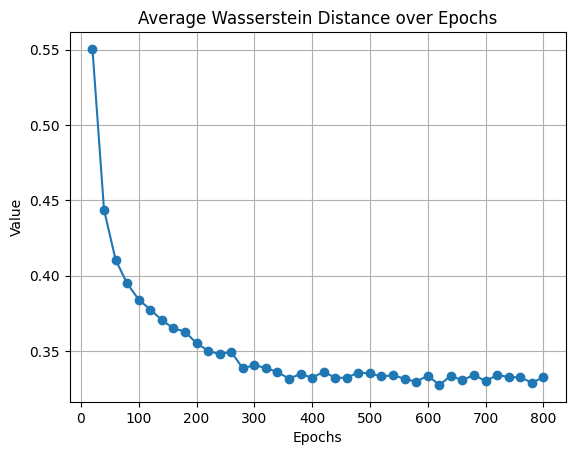

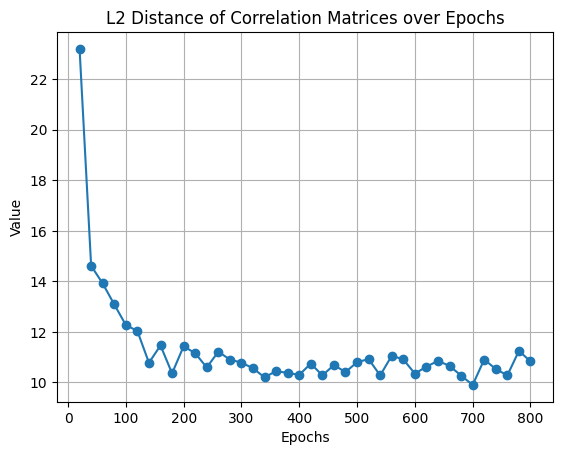

In [ ]:
import matplotlib.pyplot as plt

values = res[0]
epochs = [20 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("Average Wasserstein Distance over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

values = res[1]
epochs = [20 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("L2 Distance of Correlation Matrices over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

#Sampling

In [ ]:
d,s = evae.sample(5000)

d_tensor = d
eps = torch.randn_like(d_tensor)
# Sample from N(d, s)
sample = d_tensor + torch.sqrt(s) * eps
sample = sample.detach().cpu().numpy()

sample = scaler.inverse_transform(sample)
sample = np.expm1(sample)

In [ ]:
def get_discrete_values(tmp, start, end):
    X = embeddings_df.iloc[:, start : end]
    res=[]
    score = float('inf')
    for x in tmp:
        att=None
        score = float('inf')
        for v in X:
            s = nn.CosineEmbeddingLoss()(torch.tensor(X[v].values).unsqueeze(0), torch.tensor(x).unsqueeze(0), torch.ones(x.shape))
            if (s<score):
               score=s
               att=v
        res.append(att)
    return res


def create_final_df(sample, columns, discrete_columns, num_features):
    final_df = pd.DataFrame()
    i=0
    j=0
    col_atts_indeces = np.concatenate([np.zeros(1).astype(int), np.cumsum(ebd.values_per_column)])
    for c in columns:
        if c in discrete_columns:
            tmp = sample[:,i:i+num_features]
            attributes = get_discrete_values(tmp, col_atts_indeces[j], col_atts_indeces[j+1])
            j+=1
            final_df[c] = attributes
            i+=num_features
        else:
            final_df[c] = sample[:,i]
            i+=1
    return final_df

In [ ]:
final_df = create_final_df(sample, new_df.columns, discrete_columns, num_features)

In [ ]:
final_df['age'] = final_df['age'].astype(int)
final_df['hours-per-week'] = final_df['hours-per-week'].astype(int)
final_df['education-num'] = final_df['education-num'].astype(int)
final_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,27,Private,256895.734375,Some-college,7,Never-married,Machine-op-inspct,Not-in-family,White,Female,33,United-States,<=50K
1,28,Private,498331.281250,Bachelors,10,Married-civ-spouse,Prof-specialty,Husband,White,Male,85,United-States,>50K
2,29,Private,91022.484375,Some-college,10,Never-married,Priv-house-serv,Own-child,White,Male,25,United-States,<=50K
3,32,Private,57687.292969,9th,5,Married-civ-spouse,Other-service,Wife,White,Female,32,United-States,<=50K
4,40,Private,293081.156250,Masters,13,Never-married,Exec-managerial,Not-in-family,White,Female,40,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,Self-emp-not-inc,238276.734375,12th,9,Divorced,Machine-op-inspct,Not-in-family,White,Male,40,United-States,<=50K
4996,38,Private,571167.625000,7th-8th,6,Never-married,Handlers-cleaners,Unmarried,White,Male,42,United-States,<=50K
4997,26,Self-emp-not-inc,396708.187500,Bachelors,11,Never-married,Exec-managerial,Not-in-family,White,Male,42,Cuba,<=50K
4998,59,Private,74749.164062,Masters,11,Never-married,Prof-specialty,Own-child,White,Male,59,United-States,<=50K


In [ ]:
from google.colab import files

final_df.to_csv('final_df.csv', index=False)
files.download('final_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>